# Aggregation of Preference Orderings in Social Influence Networks
## by Moses Boudourides and Hervé Crès

In [1]:
import random, itertools, numpy as np, matplotlib.pyplot as plt, networkx as nx
from networkx.algorithms.distance_measures import center
from collections import Counter, OrderedDict
import pygraphviz
from networkx.drawing.nx_agraph import graphviz_layout

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
warnings.simplefilter('ignore')

In [2]:
nodes=random.randint(10,16) #47,52)
p=random.uniform(0.1,0.15) #0.05,0.08)
name="Erdos-Renyi random connected graph"
while True:
    G=nx.erdos_renyi_graph(nodes,p)
    if nx.is_connected(G)==True and min([d for n, d in G.degree()])>1:
        break
G=nx.Graph(G,name=name)
print("Graph G is a %s with %i nodes, p=%.3f and %i edges\n" %(str(G),len(G.nodes()),p,len(G.edges())))

Graph G is a Erdos-Renyi random connected graph with 16 nodes, p=0.113 and 23 edges



In [3]:
# nx.write_gpickle(G, "test3.gpickle")

In [4]:
# G = nx.read_gpickle("test3.gpickle")

# name="Erdos-Renyi random connected graph"
# # , p=%.3f p,
# print("Graph G is a %s with %i nodes and %i edges\n" %(str(G),len(G.nodes()),len(G.edges())))

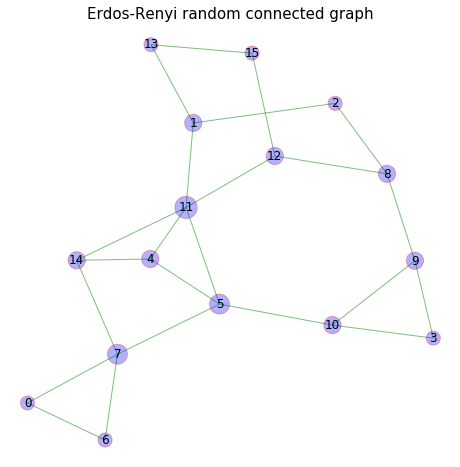

In [5]:
nsi=[100*G.degree(n) for n in G.nodes()]
labels={}
for i in G.nodes():
    labels[i]=i
pos=graphviz_layout(G)
plt.figure(figsize=(8,8));
nodes = nx.draw_networkx_nodes(G, pos, node_size=nsi, node_color="b", edgecolors='r',alpha=0.3)
nx.draw_networkx_edges(G, pos,arrowsize=20, width=1, edge_color="g", alpha=0.5)
nx.draw_networkx_labels(G,pos=pos,labels=labels,font_size=12);
plt.axis('off');
plt.title(name,fontsize=15);

13 18


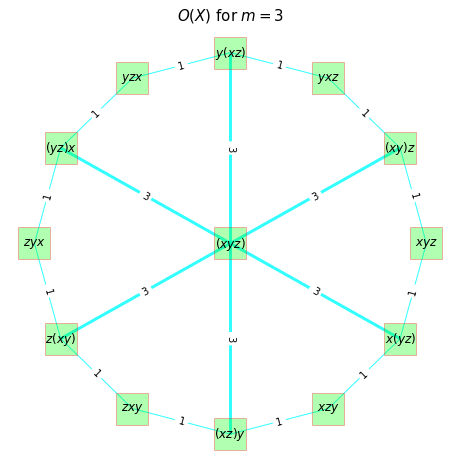

In [6]:
eds=[("$xyz$","$(xy)z$",{"weight":1}),("$(xy)z$","$yxz$",{"weight":1}),("$yxz$","$y(xz)$",{"weight":1}),
    ("$y(xz)$","$yzx$",{"weight":1}),("$yzx$","$(yz)x$",{"weight":1}),("$(yz)x$","$zyx$",{"weight":1}),
    ("$zyx$","$z(xy)$",{"weight":1}),("$z(xy)$","$zxy$",{"weight":1}),("$zxy$","$(xz)y$",{"weight":1}),
    ("$(xz)y$","$xzy$",{"weight":1}),("$xzy$","$x(yz)$",{"weight":1}),("$x(yz)$","$xyz$",{"weight":1})]
H=nx.Graph()
H.add_edges_from(eds)
hn=list(H.nodes())
for h in hn:
    if "(" in h:
        H.add_edge(h,"$(xyz)$",weight=3)
print(len(H.nodes()),len(H.edges()))
labels={}
for i in H.nodes():
    labels[i]=i
H1=nx.Graph(H)
H1.remove_node('$(xyz)$')
edge_width=[e[2]['weight'] for e in H.edges(data=True)]
posc=nx.circular_layout(H1)
posc["$(xyz)$"]=[0,0]
plt.figure(figsize=(8,8));
nodes = nx.draw_networkx_nodes(H, posc, node_size=1000, node_color="lime", node_shape="s",edgecolors='r',alpha=0.3)
nx.draw_networkx_edges(H, posc,arrowsize=20, width=edge_width, edge_color="cyan", alpha=0.8)
nx.draw_networkx_labels(H,pos=posc,labels=labels,font_size=12);
elabels = nx.get_edge_attributes(H,'weight')
nx.draw_networkx_edge_labels(H,posc,edge_labels=elabels);
plt.axis('off');
sst='$O(X)$'+" for "+'$m = 3$'
plt.title(sst,fontsize=15);

In [7]:
def votes(s):
    rate={}
    ss=s.replace("$","")
    if "(" not in ss:
        rate[ss[0]]=2
        rate[ss[1]]=1
        rate[ss[2]]=0
    if ss.startswith("("):
        if ss.endswith(")")==False:
            rate[ss[1]]=2
            rate[ss[2]]=2
            rate[ss[4]]=1
        elif ss.endswith(")"):
            rate[ss[1]]=2
            rate[ss[2]]=2
            rate[ss[3]]=2
        else:
            rate[ss[0]]=2
            rate[ss[2]]=1
            rate[ss[3]]=1
    elif ss[1]=="(":
        rate[ss[0]]=2
        rate[ss[2]]=1
        rate[ss[3]]=1
    return rate

def Borda(R):
    agorder={}
    a,b,c=0,0,0
    for r in R:
        for k,v in r.items():
            if k=='x':
                a+=v
            if k=='y':
                b+=v
            if k=='z':
                c+=v
    agorder['x']=a
    agorder['y']=b
    agorder['z']=c
    return agorder

def coro(s):
    ccoro={}
    coro={}
    sk=sorted(s.values())
    coro={k: v for k, v in sorted(s.items(), key=lambda item: item[1],reverse=True)}
    keys=list(coro.keys())
    if coro[keys[0]]>coro[keys[1]]:
        ccoro[keys[0]]=2
        if coro[keys[1]]>coro[keys[2]]:
            ccoro[keys[1]]=1
            ccoro[keys[2]]=0
        else:
            ccoro[keys[1]]=1
            ccoro[keys[2]]=1
    elif coro[keys[0]]==coro[keys[1]]:
        if coro[keys[2]]==coro[keys[0]]:
            ccoro[keys[0]]=2
            ccoro[keys[1]]=2
            ccoro[keys[2]]=2
        else:
            ccoro[keys[0]]=2
            ccoro[keys[1]]=2
            ccoro[keys[2]]=1
    return ccoro

def rord(d):
    st="$"
    coro={k: v for k, v in sorted(d.items(), key=lambda item: item[1],reverse=True)}
    keys=list(coro.keys())
    if coro[keys[0]]>coro[keys[1]]:
        st+=keys[0]
        if coro[keys[1]]>coro[keys[2]]:
            st+=keys[1]
            st+=keys[2]+"$"
        else:
            st+="("+keys[1]
            st+=keys[2]+")$"
    elif coro[keys[0]]==coro[keys[1]]:
        if coro[keys[2]]==coro[keys[0]]:
            st="$(xyz)$"
        else:
            st+="("+keys[0]
            st+=keys[1]+")"
            st+=keys[2]+"$"
    return st
    
def drob(G,H,nords):
    rob={}
    for n in G.nodes():
        nei=G.neighbors(n)
        onei=[nords[x] for x in nei]
        ronei=[votes(na) for na in onei]
        source=rord(votes(nords[n]))
        target=rord(coro(Borda(ronei)))
        dis=nx.shortest_path(H, source=source, target=target, weight='weight')
#         if len(dis)==7 or len(dis)==1:
#             rob[n]=source
#         elif len(dis)==4 and target=='$(xyz)$':
#             rob[n]==source
#         else:
#             rob[n]=dis[1]
        if len(dis)==1 or len(dis)==7: # or target=='$(xyz)$':
            rob[n]=source
#         elif len(dis)==7:
#             rob[n]='$(xyz)$'
        elif target=='$(xyz)$':
            rob[n]=source
        else:
            rob[n]=dis[1]
    return rob

def update(nords):
    u=0
    nordscopy=dict(nords)
    while True:
        u+=1
        fords=drob(G,H,nordscopy)
        diffs=set(fords.values()).intersection(set(nordscopy))
#         print(u,len(diffs))
        if fords==nordscopy:
#             print(u)
            break
        nordscopy=dict(fords)
    return fords,u

In [8]:
initial_orderings={n:random.choice(list(H.nodes())) for n in G.nodes()}
# for n in G.nodes():
#     no=random.choice(list(H.nodes()))
#     initial_orderings[n]=no
equilibrium_orderings=update(initial_orderings)[0]
steps=update(initial_orderings)[1]
# print(initial_orderings,equilibrium_orderings,steps)

tieo={}
for ki,vi in initial_orderings.items():
    for ke,ve in equilibrium_orderings.items():
        if ke==ki:
            tieo[ke]=(vi,ve)
print("In %i steps" %steps)
print("Discrete equilibrium orderings",list(set(equilibrium_orderings.values())))
for n in list(G.nodes()):
    for k,v in tieo.items():
        if k==n:
            print("Node",k,"from",v[0],"to",v[1])

In 8 steps
Discrete equilibrium orderings ['$yzx$', '$y(xz)$', '$yxz$']
Node 0 from $zxy$ to $yzx$
Node 1 from $yzx$ to $yxz$
Node 2 from $(xyz)$ to $yxz$
Node 3 from $(xy)z$ to $yxz$
Node 4 from $y(xz)$ to $yxz$
Node 5 from $(xy)z$ to $yxz$
Node 6 from $zyx$ to $yzx$
Node 7 from $(xyz)$ to $y(xz)$
Node 8 from $(xyz)$ to $yxz$
Node 9 from $yzx$ to $yxz$
Node 10 from $yxz$ to $yxz$
Node 11 from $xyz$ to $yxz$
Node 12 from $zyx$ to $yxz$
Node 13 from $(yz)x$ to $yxz$
Node 14 from $xzy$ to $yxz$
Node 15 from $xyz$ to $yxz$


In [9]:
onei=[initial_orderings[x] for x in G.nodes()]
ronei=[votes(na) for na in onei]
print(Borda(ronei))
print(coro(Borda(ronei)))
eonei=[equilibrium_orderings[x] for x in G.nodes()]
print(eonei)
eronei=[votes(na) for na in eonei]
print(Borda(eronei))
print(coro(Borda(eronei)))

{'x': 20, 'y': 24, 'z': 20}
{'y': 2, 'x': 1, 'z': 1}
['$yzx$', '$yxz$', '$yxz$', '$yxz$', '$yxz$', '$yxz$', '$yzx$', '$y(xz)$', '$yxz$', '$yxz$', '$yxz$', '$yxz$', '$yxz$', '$yxz$', '$yxz$', '$yxz$']
{'x': 14, 'y': 32, 'z': 3}
{'y': 2, 'x': 1, 'z': 0}


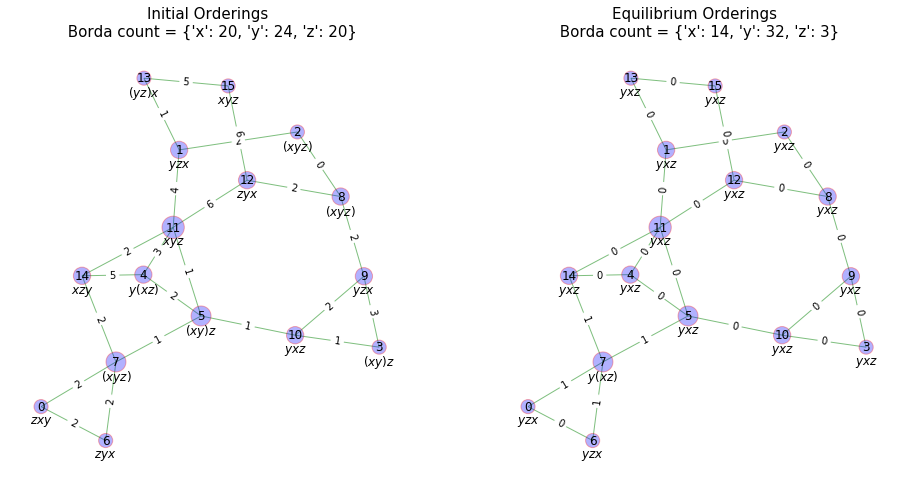

In [10]:
plt.figure(figsize=(16,8));
plt.subplot(121)
nx.set_node_attributes(G, initial_orderings, 'initial_orderings')
nsi=[100*G.degree(n) for n in G.nodes()]
labels={}
for i in G.nodes():
    labels[i]=i
pos=pos
# plt.figure(figsize=(8,8));

edis={}
for e in G.edges(data=True):
    for e in G.edges():
        o0=initial_orderings[e[0]]
        o1=initial_orderings[e[1]]
        dis=nx.shortest_path(H, source=o0, target=o1, weight='weight')
        edis[e]=len(dis)-1
for k,v in edis.items():
    G[k[0]][k[1]]["Kemeny_distance"]=v
edge_width=[e[2]['Kemeny_distance'] for e in G.edges(data=True)]

nodes = nx.draw_networkx_nodes(G, pos, node_size=nsi, node_color="b", edgecolors='r',alpha=0.3)
nx.draw_networkx_edges(G, pos,arrowsize=20, width=1, edge_color="g", edge_width=edge_width,alpha=0.5)
nx.draw_networkx_labels(G,pos=pos,labels=labels,font_size=12);
elabels = nx.get_edge_attributes(G,'Kemeny_distance')
nx.draw_networkx_edge_labels(G,pos,edge_labels=elabels);

node_attrs = nx.get_node_attributes(G, 'initial_orderings')
custom_node_attrs = {}
for node, attr in node_attrs.items():
#     print(attr)
#     att=[x.replace('attr_','a') for x in attr]
    custom_node_attrs[node] = str(attr) #''.join(attr) #'-'.join(attr)
pos_attrs = {}
for node, coords in pos.items():
    pos_attrs[node] = (coords[0], coords[1] - 15)
nx.draw_networkx_labels(G, pos_attrs, labels=custom_node_attrs,font_size=12);

plt.axis('off');
borda=Borda([votes(na) for na in [initial_orderings[x] for x in G.nodes()]])
ss="Initial Orderings \n Borda count = %s" %str(borda)
plt.title(ss,fontsize=15);
plt.margins(x=0.1, y=0.1)

plt.subplot(122)
nx.set_node_attributes(G, equilibrium_orderings, 'equilibrium_orderings')
nsi=[100*G.degree(n) for n in G.nodes()]
labels={}
for i in G.nodes():
    labels[i]=i
pos=pos
# plt.figure(figsize=(8,8));

edis={}
for e in G.edges(data=True):
    for e in G.edges():
        o0=equilibrium_orderings[e[0]]
        o1=equilibrium_orderings[e[1]]
        dis=nx.shortest_path(H, source=o0, target=o1, weight='weight')
        edis[e]=len(dis)-1
for k,v in edis.items():
    G[k[0]][k[1]]["Kemeny_distance"]=v
edge_width=[e[2]['Kemeny_distance'] for e in G.edges(data=True)]

nodes = nx.draw_networkx_nodes(G, pos, node_size=nsi, node_color="b", edgecolors='r',alpha=0.3)
nx.draw_networkx_edges(G, pos,arrowsize=20, width=1, edge_color="g", edge_width=edge_width,alpha=0.5)
nx.draw_networkx_labels(G,pos=pos,labels=labels,font_size=12);
elabels = nx.get_edge_attributes(G,'Kemeny_distance')
nx.draw_networkx_edge_labels(G,pos,edge_labels=elabels);

node_attrs = nx.get_node_attributes(G, 'equilibrium_orderings')
custom_node_attrs = {}
for node, attr in node_attrs.items():
#     print(attr)
#     att=[x.replace('attr_','a') for x in attr]
    custom_node_attrs[node] = str(attr) #''.join(attr) #'-'.join(attr)
pos_attrs = {}
for node, coords in pos.items():
    pos_attrs[node] = (coords[0], coords[1] - 15)
nx.draw_networkx_labels(G, pos_attrs, labels=custom_node_attrs,font_size=12);

plt.axis('off');
borda=Borda([votes(na) for na in [equilibrium_orderings[x] for x in G.nodes()]])
ss="Equilibrium Orderings \n Borda count = %s" %str(borda)
plt.title(ss,fontsize=15);
plt.margins(x=0.1, y=0.1)